In [6]:
import requests


import spacy

from collections import Counter, defaultdict

import pandas as pd
import os
import csv
import itertools
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import datetime

from spacy_langdetect import LanguageDetector
import plac
from spacy.lang.en import English
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from spacy import displacy
import seaborn as sbs
import geonamescache

from flair.models import TextClassifier
from flair.data import Sentence

plt.style.use('fivethirtyeight')
%matplotlib inline

I0617 10:18:49.408299 139765752624960 file_utils.py:39] PyTorch version 1.5.0 available.


**Output from NOTAMS analysis**

* Country level restrictions:

    For each country get the list of countries that the passengers are allowed to travel. The restriction information can be obtained from the NOTAMS.
    The output can be like a matrix of nxn countries, where each cell has a value -1 (no info) or 1 (open) or 2 (restricted open) or 3 (close)

* Quarantine information

**Data collection from ICAO website and humdata.org (IATA)**

The following data are collected:

1. COVID related NOTAMS from airports
2. COVID related NOTAMS from airpspaces
3. COVID-19 travel restrictions by each country

Airport NOTAMS also provide information about closure of airports


In [37]:
apt_covid_notam_lt_df = pd.read_csv("/project_data/data_asset/all_airports_covid_notams_20200616.csv")
asp_covid_notam_lt_df = pd.read_csv("/project_data/data_asset/all_airspaces_covid_notams_20200616.csv")
iata_restrictions_df = pd.read_csv("/project_data/data_asset/iata_restrictions.csv")

In [9]:
def decode_message(df):
    df['messages'] = None
    for idx,row in df.iterrows():
        if type(row['notams'])==str:
            joined_msg = []
            for m in json.loads(row['notams'])['message'].values():
                m_ = m.split("\nCREATED: ")[0]
                m_ = m_.replace('\n',' ')
                joined_msg.append(m_)
            df.at[idx,'messages'] = ' '.join(joined_msg)
            #df.at[idx,'messages'] = ' '.join(list(json.loads(row['notams'])['message'].values())).replace('\n',' ')
    
    return df


apt_covid_notam_lt_df = decode_message(apt_covid_notam_lt_df)

In [12]:
asp_covid_notam_lt_df = decode_message(asp_covid_notam_lt_df)

**The following API gives a consolidated NOTAMS of Airport and Airspace Restrictions related to COVID 19**

List of NOTAMS for airspaces and aairports referring to COVID-19 restrictions

Data dictionary of Airport COVID-19 NOTAMS

|Field|	Type|	Description|
|-----|-----|-----|
countryName|	string|	Name of the Country|
countryCode|	string|	ISO 3-Letter Code of the Country|
airportName|	string|	Name of the airport, searchable|
cityName|	string|	Name of the city, searchable|
airportCode|	string|	ICAO 4-letter code of the airport|
latitude|	number|	Latitude in Decimal degrees|
longitude|	number|	Longitude in Decimal degrees|
NoTraffic|	string|	Wheather the airport has less than one flight per day in the last 7 days (TRUEor FALSE)|
Closed|	string|	If the airport has a NOTAM which is Q-code FALC (TRUE or FALSE), which means the airport is closed |
traffic|	string|	Traffic data of the reference week, previous week and current week (json stringified format)|
notams|	string|	NOTAMS containing COVID or CORONAVIRUS key words for the airport (json stringified format)|
messages| string| NOTAMS message as a string|

In [10]:
apt_covid_notam_lt_df.head()

,Closed,NoTraffic,airportCode,airportName,cityName,countryCode,countryName,latitude,longitude,notams,traffic,messages
0,False,False,OMFJ,Fujairah Intl,Fujairah,ARE,UAE,25.112222,56.324167,"{""location"":{""745"":""OMFJ""},""StateCode"":{""745"":...","{""_id"":{""5179"":""OMFJ""},""departures"":{""5179"":1}...",RFFS CAT DOWNGRADED TO CAT 7 DUE COVID-19. CAT...
1,False,False,KAMA,Rick Husband Amarillo Intl,Amarillo,USA,USA,35.219361,-101.705917,NaN,NaN,None
2,False,False,SBMQ,Alberto Alcolumbre,Macapa,BRA,Brazil,0.050833,-51.070278,NaN,NaN,None
3,False,False,FQMA,Maputo,Maputo,MOZ,Mozambique,-25.920833,32.572639,NaN,"{""_id"":{""4628"":""FQMA""},""departures"":{""4628"":1}...",None
4,False,True,VILK,Chaudhary Charan Singh,Lucknow,IND,India,26.761944,80.883333,NaN,"{""_id"":{""280"":""VILK""},""departures"":{""280"":46},...",None


In [11]:
airport_total = len(apt_covid_notam_lt_df.airportCode.unique())
airport_open = len(apt_covid_notam_lt_df[apt_covid_notam_lt_df.Closed==False])
airport_close  = len(apt_covid_notam_lt_df[apt_covid_notam_lt_df.Closed==True])
airport_open_pt = airport_open/airport_total * 100
airport_close_pt = airport_close/airport_total * 100
print("No. of airports covered: {} \nNo.of countries covered: {}".format(airport_total,
                                                                         len(apt_covid_notam_lt_df.countryCode.unique())))
print("No. of airports open for commercial aircraft : {} ({}) \nNo.of airports closed for commercial aircraft {} ({})".format(airport_open,
                                                                                                                               airport_open_pt,
                                                                                                                               airport_close,
                                                                                                                              airport_close_pt))
   

No. of airports covered: 1484 
No.of countries covered: 225
No. of airports open for commercial aircraft : 1453 (97.911051212938) 
No.of airports closed for commercial aircraft 31 (2.0889487870619945)


In [6]:
#apt_covid_notam_lt_df.to_csv("./results/airport_NOTAMS_20200616.csv",index=False)

In [36]:
apt_covid_notam_lt_df[apt_covid_notam_lt_df.countryCode=='DEU']['messages'].iloc[6]

'COVID-19: ORDERS OF THE STATE GOVERNMENT OF BERLIN WITH THE AIM OF PREVENTING THE INTRODUCTION OR SPREAD OF INFECTIONS BY SARS-COV-2.  ALL PAX ENTERING THE FEDERAL REPUBLIC OF GERMANY AS THEIR FINAL  DESTINATION FROM COUNTRIES OTHER THAN EU MEMBER STATES, ICELAND, LIECHTENSTEIN, NORWAY, SWITZERLAND AND THE UNITED KINGDOM AND NORTHERN IRELAND DIRECT OR VIA TRANSFER (1) MUST STAY IN QUARANTINE  FOR 14 DAYS AFTER ARRIVAL AND (2) MUST CONTACT LOCAL HEALTH  AUTHORITY OF THEIR FINAL DESTINATION IMMEDIATLY. THESE REGULATIONS  DO NOT APPLY FOR CREW MEMBERS. THE CREW MUST PROVIDE INFORMATION  ABOUT THESE REGULATIONS TO ALL PAX INFLIGHT. AIRLINES MUST PROVIDE  COMPLETE DATA OF AFFECTED PAX (FULL NAME, DATE OF BIRTH AND ADDRESS OF EACH PAX) TO THE LOCAL HEALTH AUTHORITY REINICKENDORF UNDER GESUNDHEITSAMT(AT)REINICKENDORF.BERLIN.DE. COVID-19: FACE MASKS MANDATORY IN ALL TERMINAL BUILDINGS. PASSENGER MUST DISEMBARK IN SMALL GROUPS ONLY. VFR RESTRICTION WILL TAKE PLACE FOR INTERNATIONAL AIRPORTS. F

**Analysis**

Two main analysis were carried out:

1. Identification of quarantine duration mentioned in NOTAMS

2. Mention of other country names in each country's NOTAMS to get an idea of the restriction levels carried out by each country

Before carrying out the analysis, the text data has to be preprocessed to remove unnecessary words and special characters. Moreover, the analysis was carried out only for the top 19 busiest countries

Preprocessing of text

In [13]:
# Busy airports countries - International

main_country_codes = ['USA','CHN','DEU','GBR','JPN','MEX','HKG','KOR','CAN',
                      'ARE','ESP','FRA','NLD','ITA','SGP','IND','NZL','AUS','NOR']

# Regular nlp
#nlp = spacy.load('en_core_web_md')

############
#Stop words#
############

nlp_ = spacy.load('en_core_web_md')

# Adding stop words
new_stop_words = ["create","source","euecyiyn",'etczyoyx','ppr','tel']

#Remove airport codes
new_stop_words.extend([ac.lower() for ac in list(apt_covid_notam_lt_df.airportCode.values)])

for new_word in new_stop_words:
    nlp_.vocab[new_word].is_stop = True
    

mapping = {'clsd':'closed','avbl':'available','intl':'international','emerg':'emergency','pax':'passenger',
           'acft':'aircraft','flt':'flight','dem.':'democratic','rep.':'republic','isl.':'islands',
           'fed.':'federation','opr':'operating','chg':'change','ad':'aerodrome'}

# Language detection only for selected countries!
non_english_NOTAMS = ['ITA','CHL']

**Collection of countries**

In [14]:
gc = geonamescache.GeonamesCache()

# gets nested dictionary for countries
countries = gc.get_countries()

# gets nested dictionary for countries
cities = gc.get_cities()

countries_list = []
for v in countries.values():
    countries_list.append(v['name'].lower())

cities_list = []
for c in cities.values():
    cities_list.append(c['name'].lower())

**Sentence tokenisation of messages**

We are breaking the messages into sentences and we use the sentences for our classification as these are short messages. Only in some cases we may require a couple of sentences to understand the context!

Since we are building a NOTAMSesque model we keep the punctuations, quotes, etc!

**Challenges!**

- Though hypenated lists are converted to a single sentence,each numbered list is considered as a single sentence

- Since some countries such as USA or Korea have been spelt differently in different NOTAMS we have to use a phrase matcher to capture these different spellings. Currently, we use the geonamescache list as well as a manual mapping list!

- Remove non english sentences

- Some countries are not identified as GPE . For example, In JPN's message, countries such as india, china, pakistan, USA were not identified: (1)asia  india(note1), indonesia, republic of korea, singapore, thailand,  taiwan, china(including hong kong and macau), islamic republic of pakistan(note1), people's republic of bangladesh(note1),  philippines, brunei, viet nam, malaysia, republic of maldives (2)oceania  australia, new zealand (3)north america  canada, united states of america 

- Iran restriction in Germany (Bremen's airspace NOTAM) not identified! --solved

In [15]:
manual_mapping = {'united states':['us','u.s.','usa','united states of america'],'united kingdom':['uk','the united kingdom'],
                 'antigua and barbuda':['antigua','barbuda'],'hong kong':['hong kong sar'],
                 'united arab emirates':['uae'],'vietnam':['viet nam'],
                 'russia':['russian federation'],'iran':['the islamic republic of iran'],
                 'germany':['the federal republic of germany'],'brunei':['brunei darussalam'],
                 'republic of the congo':['congo'],'ivory coast':["cote d'ivoire"],
                 'saint kitts and nevis':['nevis'],'singapore':['the republic of singapore']}

In [17]:
#nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
sentences_dt = dict()
sentences_dt['message'] = []
sentences_dt['country_code'] = []
sentences_dt['tokens'] = []
sentences_dt['GPE_ents'] = []

consolidated_dt = dict()
consolidated_dt['message'] = []
consolidated_dt['country_code'] = []

for cc in main_country_codes:
    # Joining airport, airspace NOTAM and IATA data
    airport_message = '. '.join(apt_covid_notam_lt_df[apt_covid_notam_lt_df.countryCode==cc]['messages'].dropna().values)
    airspace_message = '. '.join(asp_covid_notam_lt_df[asp_covid_notam_lt_df.countryCode==cc]['messages'].dropna().values)

    message = airport_message + '. ' + airspace_message

    if cc in iata_restrictions_df.iso3.unique():
        iata_message = ' '.join(iata_restrictions_df[iata_restrictions_df.iso3==cc]['info'].dropna().values).replace("\n",' ')
        message += ". " + iata_message

    # Remove any extra space
    message = message.replace("  "," ")

    # To combine bullet points in IATA data
    message = message.replace(". -",",")

    # Remove double periods to single period 
    message = message.replace("..",".")

    #############################
    ## mapping, lower, language #
    #############################
    #Make everything to lower case
    message = message.lower()

    # Mapping short terms to actual word
    for s_, w in mapping.items():
        message = message.replace(s_,w)

    # Remove duplicated sentences and sentences less than 2 words
    non_duplicated_sentences = []
    for sent in sent_tokenize(message):
        if len(word_tokenize(sent)) > 2:
            if not sent in non_duplicated_sentences:
                non_duplicated_sentences.append(sent)
    
    # Adding message to df
    consolidated_dt['message'].append(' '.join(non_duplicated_sentences))
    consolidated_dt['country_code'].append(cc)
    

    # Get tokens for each sentence!
    for sentence in non_duplicated_sentences:
        sent_ = nlp_(sentence)

        # Cleaning text
        tokens = []
        for token in sent_:
            #print(word)
            # Remove punctuation and numbers
            if token.is_alpha:
                # Lemma
                lemma_text = token.lemma_
                #Remove stop words
                if not nlp_.vocab[lemma_text].is_stop:
                    tokens.append(lemma_text)
        # GPE entities
        GPE_ents = []
        for t in sent_.ents:
            if "GPE" in t.label_:
                gpe_text = t.text
                # Manual mapping of misspelt countries. List has to be extended!
                for k,v in manual_mapping.items():
                    if gpe_text in v:
                        gpe_text=k
                # Add only countries that are in the list
                if gpe_text in countries_list:
                    GPE_ents.append(gpe_text)
        
        if len(GPE_ents) == 0:
            GPE_ents = None

        # Append to dict
        if len(tokens) > 0:
            sentences_dt['message'].append(sentence)
            sentences_dt['country_code'].append(cc)
            sentences_dt['tokens'].append(tokens)
            sentences_dt['GPE_ents'].append(GPE_ents)

In [19]:
sentences_df = pd.DataFrame(sentences_dt)
consolidated_df = pd.DataFrame(consolidated_dt)

In [20]:
consolidated_df

,message,country_code
0,"for aircraft parking on mil ramp, if a passeng...",USA
1,shanghai introduces 14-day quarantine for thos...,CHN
2,covid-19: change of opening hours aerodrome op...,DEU
3,covid-19 information: due to closure of termin...,GBR
4,due to the spreaerodrome of coronavirus infect...,JPN
5,changed ap hours of ser for contingency covid-...,MEX
6,hong kong international airport (hkg) is opera...,HKG
7,civ ais operational hours : 2100(z)-1430(z) du...,KOR
8,covid-19: flight restrictions until further no...,CAN
9,rffs cat downgraerodromeed to cat 7 due covid-...,ARE


**Quarantine duration**

To identify quarantine duration, a simple regex search of the word "quarantine" or "isolation" was carried out and the date entity in the resulting text was extracted. 


In [21]:
quarantine_duration_df = consolidated_df.copy()
quarantine_duration_df['quarantine_text'] = ""
quarantine_duration_df['quarantine_days'] = ""

for idx, row in quarantine_duration_df.iterrows():
    quarantine_days = []
    quarantine_text = []
    message = row['message']
    doc_ = nlp_(message)
    for sent in doc_.sents:
        if ('quarantine' in sent.text) | ('isolation' in sent.text):
            for ent in nlp_(sent.text).ents:
                if (ent.label_ == "DATE") & (("DAY" in ent.text.upper())|("WEEK" in ent.text.upper())):
                    quarantine_days.append(ent.text)
                    quarantine_text.append(sent.text)
                    spacy.displacy.render(nlp_(sent.text), jupyter=True, style='ent',options={'ents':['DATE']})
    if not len(quarantine_days) == 0:
        quarantine_duration_df.loc[idx,'quarantine_days'] = ",".join(quarantine_days)
    if not len(quarantine_text) == 0:
        quarantine_duration_df.loc[idx,'quarantine_text'] = " ".join(quarantine_text)

In [22]:
quarantine_duration_df

,message,country_code,quarantine_text,quarantine_days
0,"for aircraft parking on mil ramp, if a passeng...",USA,"passengers who have been in austria, belgium, ...","the past 14 days,14 days"
1,shanghai introduces 14-day quarantine for thos...,CHN,shanghai introduces 14-day quarantine for thos...,"14-day,14 days,14-day,the past 14 days,14-day,..."
2,covid-19: change of opening hours aerodrome op...,DEU,all passenger entering the federal republic of...,"14 days,14 days,14 days,several days,14 days"
3,covid-19 information: due to closure of termin...,GBR,passengers are subject to self-isolation for 1...,14 days
4,due to the spreaerodrome of coronavirus infect...,JPN,passengers and airline crew who have been in a...,"the past 14 days,the past 14 days"
5,changed ap hours of ser for contingency covid-...,MEX,,
6,hong kong international airport (hkg) is opera...,HKG,all passengers who are eligible to enter hong ...,"14 days,the past 14 days,14-day,the past 14 da..."
7,civ ais operational hours : 2100(z)-1430(z) du...,KOR,passengers are subject to quarantine for 14 da...,"14 days,1 or 2 days"
8,covid-19: flight restrictions until further no...,CAN,passengers must have a quarantine plan upon ar...,"14 days,14-day,14 days,14 days,14 days"
9,rffs cat downgraerodromeed to cat 7 due covid-...,ARE,all arriving passengers will be required to se...,14 days


In [89]:
#quarantine_duration_df.to_csv("./results/quarantine_duration_main_countries_20200605.csv",index=False)

**Observation**

* Most countries have a quarantine duration of 14 days if travel is permitted to their country except Norway where the quarantine duration is 10 days.

* The quarantine duration has to be checked along with the 'quarantine text' column to ensure the exact quarantine regulations!!

**Mention of country names**

In this analysis we extract all country names mentioned in the NOTAMS. This gives a rough understanding of how the restrictions have been placed in each country.

- If other country names are mentioned in the NOTAMS it means that the country has placed selective restrictions!

- If no other country name is mentioned in the NOTAMS it can either mean the country has placed no restriction or it has placed complete restriction

In [23]:
geo_country_map = {'USA':'united states',
                     'CHN':'china',
                     'DEU':'germany',
                     'GBR':'united kingdom',
                     'JPN':'japan',
                     'MEX':'mexico',
                     'HKG':'hong kong',
                     'KOR':'south korea',
                     'CAN':'canada',
                     'ARE':'united arab emirates',
                     'ESP':'spain',
                     'FRA':'france',
                     'NLD':'netherlands',
                     'ITA':'italy',
                     'SGP':'singapore',
                     'IND':'india',
                     'NZL':'new zealand',
                     'AUS':'australia',
                     'NOR':'norway'}


In [24]:
valid_row = []
for idx, r in sentences_df.dropna(subset=['GPE_ents']).iterrows():
        ct_lt = r['GPE_ents']
        #drop duplicate names
        ct_lt = list(set(ct_lt))
        if not ((len(ct_lt)== 1) & (geo_country_map[r['country_code']] in ct_lt)):
            valid_row.append(r)

In [25]:
other_country_mention_df = pd.DataFrame(valid_row)

In [26]:
other_country_mention_df

,message,country_code,tokens,GPE_ents
3,canaerodromeian border closure to all nonessen...,USA,"[canaerodromeian, border, closure, nonessentia...","[austria, belgium, brazil, china, denmark, est..."
5,"3. passengers who have been in austria, belgiu...",USA,"[passenger, austria, belgium, brazil, china, p...","[austria, belgium, brazil, china, denmark, est..."
6,4. passports issued to nationals of belarus wh...,USA,"[passport, issue, national, belarus, expire, a...",[belarus]
7,"*****internal restrictions: all 50 us states, ...",USA,"[internal, restriction, state, puerto, rico, v...","[united states, puerto rico]"
15,aviation authorities to extend restrictions on...,CHN,"[aviation, authority, extend, restriction, int...","[china, china, hong kong]"
19,4. passengers who live in or have been in fran...,CHN,"[passenger, live, france, germany, iran, italy...","[france, germany, iran, italy, japan, spain, u..."
30,this includes foreign nationals with apec busi...,CHN,"[include, foreign, national, apec, business, t...","[hong kong, macao]"
38,all land border crossings between china and ru...,CHN,"[land, border, crossing, china, russia, close,...","[china, russia]"
39,yunnan province has banned citizens from leavi...,CHN,"[yunnan, province, ban, citizen, leave, countr...","[vietnam, laos, myanmar]"
41,"so far, ""fast-track"" commercial charter flight...",CHN,"[far, fast, track, commercial, charter, flight...","[germany, south korea]"


In [28]:
# FLAIR
classifier = TextClassifier.load('en-sentiment')

2020-06-17 10:23:52,404 loading file /home/wsuser/.flair/models/sentiment-en-mix-distillbert.pt


I0617 10:23:52.899330 139765752624960 configuration_utils.py:265] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json from cache at /home/wsuser/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c
I0617 10:23:52.901489 139765752624960 configuration_utils.py:301] Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 30522
}

I0617 10:23:53.250747 139765752624960 tokenization_utils.py:1022] loading file https://s3.amazona

In [29]:
for cc in main_country_codes:
    print(cc)
    for idx, sentence_ in other_country_mention_df[other_country_mention_df.country_code==cc].iterrows():
        sent = nlp_(sentence_['message'])
        displacy.render(sent,jupyter=True, style="ent")
        sentence = Sentence(sent.text)
        classifier.predict(sentence)
        print(sentence.labels)
        #print("--------------")
        #break

USA


[NEGATIVE (0.9954)]


[NEGATIVE (0.9593)]


[NEGATIVE (0.7802)]


[NEGATIVE (0.9965)]
CHN


[NEGATIVE (0.9977)]


[NEGATIVE (0.9917)]


[POSITIVE (0.61)]


[NEGATIVE (0.9717)]


[NEGATIVE (0.9917)]


[POSITIVE (0.508)]


[NEGATIVE (0.8216)]


[NEGATIVE (0.9392)]
DEU


[NEGATIVE (0.8081)]


[NEGATIVE (0.9642)]


[NEGATIVE (0.9536)]


[NEGATIVE (0.9984)]


[NEGATIVE (0.9909)]


[NEGATIVE (0.9975)]


[NEGATIVE (0.9205)]


[POSITIVE (0.9833)]


[NEGATIVE (0.6405)]


[POSITIVE (0.9753)]


[NEGATIVE (0.9996)]


[NEGATIVE (0.9569)]
GBR


[NEGATIVE (0.8393)]
JPN


[NEGATIVE (0.9996)]


[NEGATIVE (0.8058)]


[NEGATIVE (0.993)]


[NEGATIVE (0.7419)]


[NEGATIVE (0.9953)]


[NEGATIVE (0.9967)]


[NEGATIVE (0.9995)]


[NEGATIVE (0.997)]


[NEGATIVE (0.9994)]


[NEGATIVE (0.9928)]
MEX


[NEGATIVE (0.9324)]
HKG


[NEGATIVE (0.9959)]


[NEGATIVE (0.9661)]


[NEGATIVE (0.9031)]


[NEGATIVE (0.6568)]


[NEGATIVE (0.9964)]


[NEGATIVE (0.9852)]


[NEGATIVE (0.8216)]


[NEGATIVE (0.8569)]


[NEGATIVE (0.7034)]


[POSITIVE (0.8538)]


[NEGATIVE (0.9894)]


[NEGATIVE (0.9997)]


[NEGATIVE (0.9885)]
KOR


[NEGATIVE (0.9669)]


[NEGATIVE (0.995)]


[NEGATIVE (0.9993)]


[NEGATIVE (0.9881)]


[NEGATIVE (0.9428)]
CAN


[NEGATIVE (0.9891)]


[NEGATIVE (0.9854)]


[NEGATIVE (0.9767)]


[NEGATIVE (0.9981)]
ARE
ESP


[NEGATIVE (0.9971)]


[NEGATIVE (0.9952)]


[POSITIVE (0.5031)]


[POSITIVE (0.5712)]
FRA


[NEGATIVE (0.9913)]


[POSITIVE (0.7005)]


[NEGATIVE (0.9928)]


[NEGATIVE (0.9072)]
NLD


[NEGATIVE (0.998)]
ITA


[NEGATIVE (0.9788)]


[NEGATIVE (0.9612)]


[NEGATIVE (0.9605)]


[NEGATIVE (0.9805)]


[NEGATIVE (0.977)]
SGP


[POSITIVE (0.8387)]


[NEGATIVE (0.9989)]
IND


[NEGATIVE (0.6415)]
NZL


[NEGATIVE (0.98)]


[NEGATIVE (0.9972)]
AUS


[POSITIVE (0.786)]


[POSITIVE (0.8558)]


[NEGATIVE (0.9993)]


[POSITIVE (0.5805)]
NOR


[NEGATIVE (0.9943)]


[NEGATIVE (0.9873)]


[NEGATIVE (0.9601)]


[NEGATIVE (0.8622)]


[NEGATIVE (0.9961)]


[NEGATIVE (0.9995)]


[NEGATIVE (0.9947)]


[NEGATIVE (0.9674)]


In [30]:
country_matrix_columns = list(set(sum(list(sentences_df['GPE_ents'].dropna().values), [])))
country_mention_df = pd.DataFrame(dict(),columns=country_matrix_columns)

for cc in sentences_df.country_code.unique():
    row_dict = dict()
    counts_ = Counter((sum(list(sentences_df[sentences_df.country_code==cc]['GPE_ents'].dropna().values), [])))
    for k,v in counts_.items():
        row_dict[k] = v
    
    d__ = pd.DataFrame(row_dict,index=[cc])
    country_mention_df = country_mention_df.append(d__)

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [31]:
country_matrix_columns = list(set(sum(list(other_country_mention_df['GPE_ents'].dropna().values), [])))
country_mention_df = pd.DataFrame(dict(),columns=country_matrix_columns)

for cc in other_country_mention_df.country_code.unique():
    row_dict = dict()
    counts_ = Counter((sum(list(other_country_mention_df[other_country_mention_df.country_code==cc]['GPE_ents'].dropna().values), [])))
    for k,v in counts_.items():
        row_dict[k] = v
    
    d__ = pd.DataFrame(row_dict,index=[cc])
    country_mention_df = country_mention_df.append(d__)

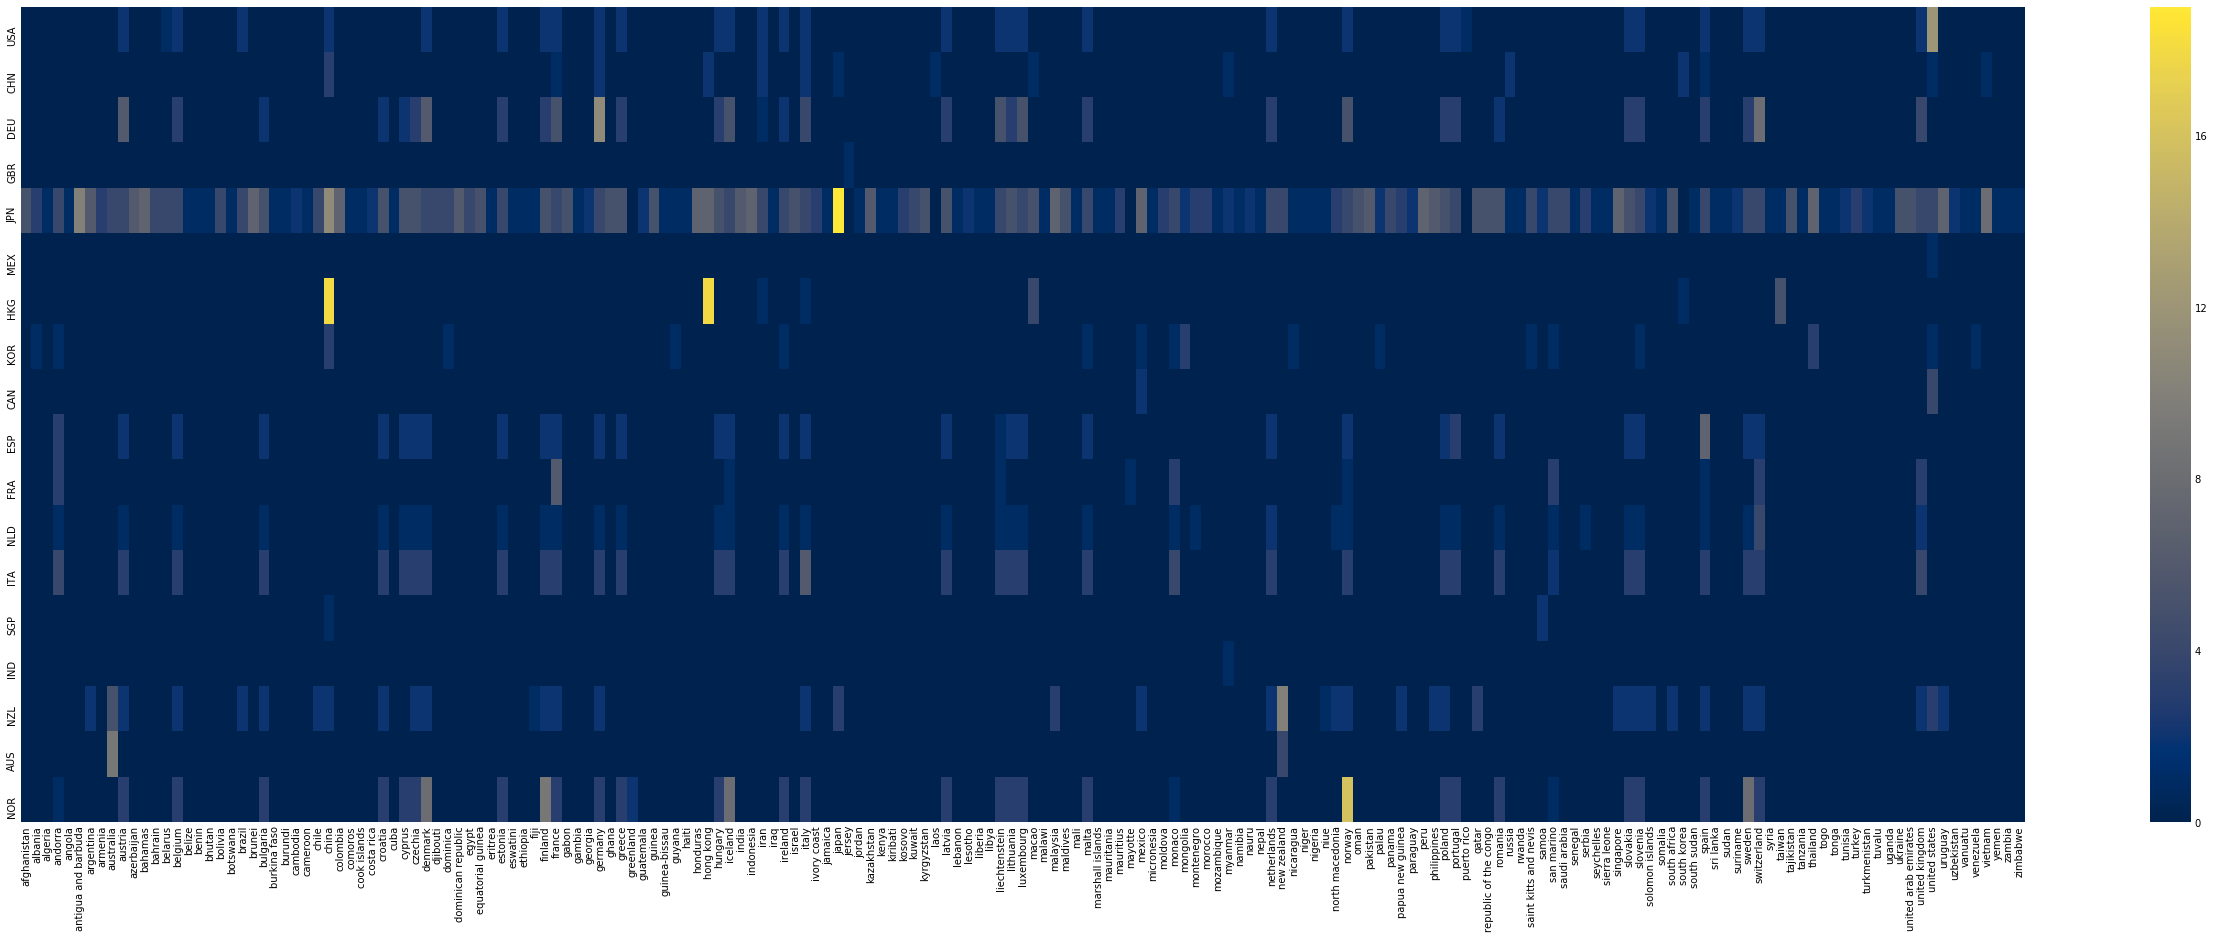

In [32]:
plt.figure(figsize=(40,15))
sbs.heatmap(country_mention_df.fillna(0),cmap='cividis')
plt.show()

In [28]:
sentences_df

,message,country_code,tokens,GPE_ents
0,"for aircraft parking on mil ramp, if a passeng...",USA,"[aircraft, parking, mil, ramp, passenger, crew...",None
1,all aircrew (civ and mil) will contact command...,USA,"[aircrew, civ, mil, contact, command, post, br...",None
2,aircrew will monitor all persons on board for ...,USA,"[aircrew, monitor, person, board, symptom, fli...",None
3,canaerodromeian border closure to all nonessen...,USA,"[canaerodromeian, border, closure, nonessentia...","[austria, belgium, brazil, china, denmark, est..."
4,2. passengers who have been in one of the coun...,USA,"[passenger, country, list, bullet, number, pas...",None
...,...,...,...,...
1229,"gatherings above 50 people are prohibited, inc...",NOR,"[gathering, people, prohibit, include, major, ...",None
1230,internal flights will continue to operate.,NOR,"[internal, flight, continue, operate]",None
1231,travel within norway should be for essential p...,NOR,"[travel, norway, essential, purpose]",[norway]
1232,relaxation in restrictions: all airports will ...,NOR,"[relaxation, restriction, airport, reopen, june]",None


**Observation**

* Only country GPE entities are included. For some countries, the restrictions were identified by nationalities (NORP) and not by country names. 

* Japan has placed an exensive restriction whereas Australia has no mention of any other country indicating complete closure!

* Countries with darker lines indicate almost complete restriction!

* Note that some NOTAMs indicate a possibility of opening in future!


In [87]:
#iata_restrictions_df[iata_restrictions_df.iso3=='AUS']['info'].values

In [57]:
all_df.head()

,country_name,countries_sentences,countries_gpe_entities,countries_norp_entities,countries_date_entities
4,USA,u.s. government expected to suspend passenger ...,[china],None,None
5,USA,hawaii to extend 14-day quarantine beyond 30 j...,None,None,[30 june]
6,USA,"u.s. government bans travel to, from brazil (a...",[brazil],None,None
7,USA,u.s. government extends ban on nonessential tr...,"[canada, mexico]",None,None
8,USA,"shared borders through 22 june (reuters, 19.05...",None,None,[22 june]


canadian border closure to all nonessential travel to be extended beyond 21 june (cbc, 10.06.2020) 1. passengers who have transited or have been in austria, belgium, brazil, china (people's republic), czechia, denmark, estonia, finland, france, germany, greece, hungary, iceland, iran, ireland (republic), italy, latvia, liechtenstein, lithuania, luxembourg, malta, netherlands, norway, poland, portugal, slovakia, slovenia, spain, sweden, switzerland or in the united kingdom (excluding overseas territories outside of europe), in the past 14 days are not allowed to enter the usa,this does not apply to: - nationals and permanent residents of the usa; - spouses of nationals and of permanent residents of the usa; - parents/legal guardians of an unmarried and younger than 21 years national or permanent resident of the usa; - the unmarried and younger than 21 years brother or sister of a national or permanent resident of the usa, who is unmarried and younger than 21 years; - the child/foster child/ward of a national or permanent resident of the usa; - passengers with the following visas: a-1, a-2, c-1, c-1/d, c-2, c-3, d, e-1(as an employee of tecro or teco or the employee's immediate family members), g-1, g-2, g-3, g-4, ir-4, ih-4, nato-1 through nato-4, or nato-6 visa; - members of the u.s. armed forces, spouses, and children of members of the u.s. armed forces; - passengers with evidence of traveling at the invitation of the usa government for a purpose related to the containment/mitigation of the coronavirus (covid-19); - passengers with documents issued by the u.s. department of homeland security, u.s. customs and border protection, or u.s. department of state indicating that the passenger is exempt from the restriction; - b1 crew crewmembers that are engaged in lightering, outer continental shelf (ocs) activity, wind farm activity, private air/sea crew and other similar crewmember actives.","USA",